In [1]:
import os
from dotenv import load_dotenv
import vanna
from vanna.remote import VannaDefault
from vanna.flask import VannaFlaskApp

In [2]:
load_dotenv()

True

In [3]:
vn = VannaDefault(model='mysql_rag', api_key=os.getenv("vanna_api_key"))

In [4]:
vn.connect_to_mysql(host=os.getenv('DB_HOST'),
                    dbname=os.getenv('DB_NAME'),
                    user=os.getenv('DB_USER'),
                    password=os.getenv('DB_PASSWORD'),
                    port=3306)

## Training

In [9]:
df_information_schema = vn.run_sql("""
    SELECT *
    FROM INFORMATION_SCHEMA.TABLES
    WHERE TABLE_SCHEMA = 'inventory'
""")

In [10]:
# Generate the training plan
plan = vn.get_training_plan_generic(df_information_schema)

In [11]:
for table_name in plan.get_summary():
    print(table_name)

Train on Information Schema: def.inventory item
Train on Information Schema: def.inventory item_price
Train on Information Schema: def.inventory item_stock
Train on Information Schema: def.inventory stockroom


In [12]:
vn.train(plan=plan)

### Train on DDL

In [13]:
vn.train(ddl = """
CREATE TABLE IF NOT EXIST item (
item_id INT PRIMARY KEY,
item_name VARCHAR(150),
item_description VARCHAR(150),
department_id INT,
default_price_id INT,
has_expiration INT,
concept_id INT,
creator INT,
date_created DATETIME,
changed_by INT,
date_changed DATETIME,
retired INT,
retired_by INT,
date_retired DATETIME,
retire_reason VARCHAR(50),
uuid VARCHAR(100),
has_physical_inventory INT,
default_expiration_period INT,
concept_accepted INT,
minimun_quantity INT,
buying_price DOUBLE         
)
""")

Adding ddl: 
CREATE TABLE IF NOT EXIST item (
item_id INT PRIMARY KEY,
item_name VARCHAR(150),
item_description VARCHAR(150),
department_id INT,
default_price_id INT,
has_expiration INT,
concept_id INT,
creator INT,
date_created DATETIME,
changed_by INT,
date_changed DATETIME,
retired INT,
retired_by INT,
date_retired DATETIME,
retire_reason VARCHAR(50),
uuid VARCHAR(100),
has_physical_inventory INT,
default_expiration_period INT,
concept_accepted INT,
minimun_quantity INT,
buying_price DOUBLE         
)



'288407-ddl'

### Train on Documentation

In [14]:
vn.train(documentation="This contains item inventory on a healthcare platform such as the item name, buying price, and whether it has physical inventory.")

Adding documentation....


'1813230-doc'

### Train on SQL query

In [15]:
vn.train(question="What are the item names of the items that do not have physical inventory?",
         sql = "SELECT item_name * FROM item WHERE has_physical_inventory = 0'")

'59de8a4c5423505eed60540bb7e26b7f-sql'

In [16]:
vn.train(sql = "SELECT item_name * FROM item WHERE has_physical_inventory = 1'")

Question generated with sql: What are the names of items that have physical inventory available? 
Adding SQL...


'd4084fe4d298c324c9462d565f0e7cab-sql'

In [17]:
vn.train(question="What is the average price of items with physical inventory and those without",
         sql="SELECT has_physical_inventory,AVG(price) AS average_price FROM item INNER JOIN item_price ON item.default_price_id = item_price.item_price_id GROUP BY has_physical_inventory")

'7dfaa490fb0dd23986c66b1c351faf1b-sql'

In [18]:
vn.train(question="Which storeroom has the most inventory?",
        sql="SELECT item_stock.stockroom_id, stockroom_name, SUM(item_stock.quantity) AS total_quantity FROM item_stock INNER JOIN stockroom ON item_stock.stockroom_id = stockroom.stockroom_id GROUP BY item_stock.stockroom_id, stockroom_name ORDER BY total_quantity DESC LIMIT 1")

'd0761db3a418ce6b4f3d8c6af248b14b-sql'

In [19]:
vn.train(question="What items are running out of stock? Items that have a quantity of less than 10",
        sql="SELECT item.item_id, item.item_id, quantity FROM item_stock INNER JOIN item ON item_stock.item_id = item.item_id WHERE quantity < 10 ORDER BY quantity DESC")

'601039e407b71a4447dc8c3e934378cc-sql'

In [20]:
vn.get_training_data()

,id,training_data_type,question,content
0,405337-sql,sql,Which storeroom has the most inventory?,"SELECT item_stock.stockroom_id, stockroom_name..."
1,1813230-doc,documentation,None,This contains item inventory on a healthcare p...
2,1813229-doc,documentation,None,The following columns are in the stockroom tab...
3,405336-sql,sql,What is the average price of items with physic...,"SELECT has_physical_inventory,AVG(price) AS av..."
4,1813226-doc,documentation,None,The following columns are in the item table in...
5,288407-ddl,ddl,None,\nCREATE TABLE IF NOT EXIST item (\nitem_id IN...
6,405334-sql,sql,What are the item names of the items that do n...,SELECT item_name * FROM item WHERE has_physica...
7,405338-sql,sql,What items are running out of stock? Items tha...,"SELECT item.item_id, item.item_id, quantity FR..."
8,1813228-doc,documentation,None,The following columns are in the item_stock ta...
9,405335-sql,sql,What are the names of items that have physical...,SELECT item_name * FROM item WHERE has_physica...


SELECT DISTINCT stockroom_name FROM inventory.stockroom;
  stockroom_name
0       Pharmacy
1          Store
2       Casualty
3            Lab
4       Security
5         triage


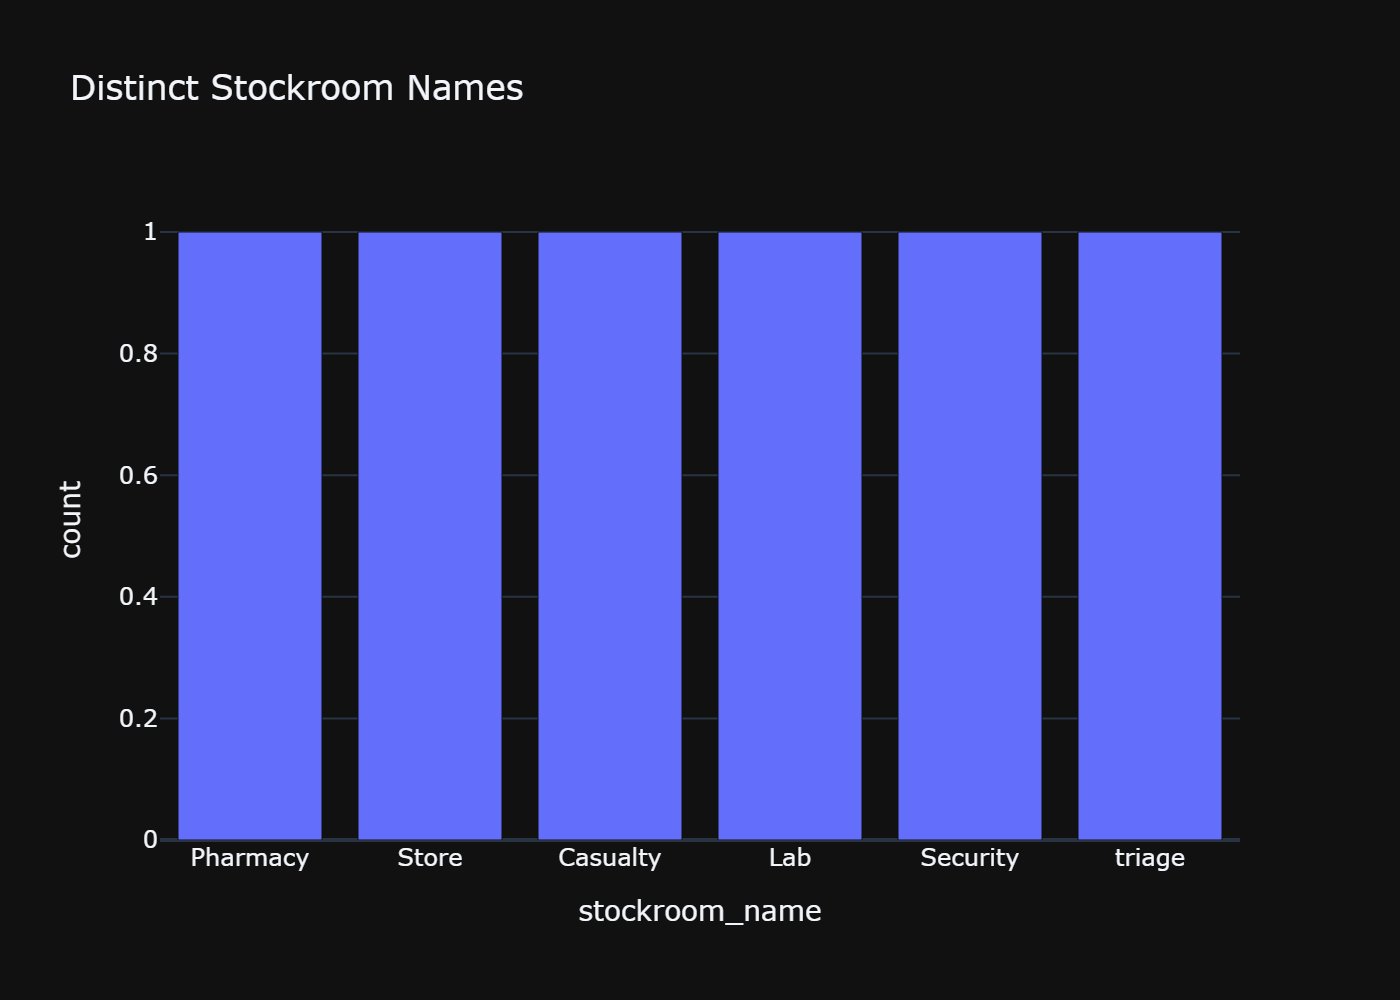

('SELECT DISTINCT stockroom_name FROM inventory.stockroom;',
   stockroom_name
 0       Pharmacy
 1          Store
 2       Casualty
 3            Lab
 4       Security
 5         triage,
 Figure({
     'data': [{'alignmentgroup': 'True',
               'hovertemplate': 'stockroom_name=%{x}<br>count=%{y}<extra></extra>',
               'legendgroup': '',
               'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
               'name': '',
               'offsetgroup': '',
               'orientation': 'v',
               'showlegend': False,
               'textposition': 'auto',
               'type': 'bar',
               'x': array(['Pharmacy', 'Store', 'Casualty', 'Lab', 'Security', 'triage'],
                          dtype=object),
               'xaxis': 'x',
               'y': array([1, 1, 1, 1, 1, 1]),
               'yaxis': 'y'}],
     'layout': {'barmode': 'relative',
                'legend': {'tracegroupgap': 0},
                'template': '...',
         

In [23]:
vn.ask("can you give me distinct stockroom names from stockroom table?", allow_llm_to_see_data=True)

In [25]:
app = VannaFlaskApp(vn, allow_llm_to_see_data=True)
app.run()

Your app is running at:
http://localhost:8084
 * Serving Flask app 'vanna.flask'
 * Debug mode: on
None
{'function_name': 'get_storeroom_with_most_inventory', 'description': 'Which storeroom has the most inventory?', 'arguments': [], 'sql_template': 'SELECT item_stock.stockroom_id, stockroom_name, SUM(item_stock.quantity) AS total_quantity FROM item_stock INNER JOIN stockroom ON item_stock.stockroom_id = stockroom.stockroom_id GROUP BY item_stock.stockroom_id, stockroom_name ORDER BY total_quantity DESC LIMIT 1;', 'post_processing_code_template': ''}
{}
{}
{}
{'function_name': 'get_top_items_by_quantity', 'description': 'What are the names and the quantities of the items with the highest quantities (top {limit})?', 'arguments': [{'name': 'limit', 'description': 'The number of top items to retrieve based on quantity', 'general_type': 'STRING', 'is_user_editable': True}], 'sql_template': 'SELECT item_name, quantity FROM item INNER JOIN item_stock ON item.item_id = item_stock.item_id ORDE